Remove warnings:

In [41]:
import warnings
warnings.filterwarnings('ignore')

Parameters:

In [42]:
p = 0.95 #significance
scale = 56 #weeks per year

Custom functions:

In [43]:
def wrd_div(n, d):
    return n / d if d else 0

def est_coef(x, y): 
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 

    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 

    k = SS_xy / SS_xx 
    b = m_y - k*m_x 
  
    return(b, k)

Import libraries:

In [44]:
from statistics import median
import statsmodels.api as sm
import statistics

import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.dates as dates
import plotly.graph_objects as go

Read data:

In [45]:
labels = ['TLT', 'SPY', 'GOLD']
df = pd.ExcelFile('data/data.xlsx').parse('data')[['DATE', 'TLT', 'SPY', 'GOLD']]

Format data:

In [46]:
df = df.dropna(how='any', axis=0)
df['DATE'] =  pd.to_datetime(df['DATE']).dt.date 

Show time period and records number:

In [47]:
print('Total volume:', len(df), 'records')
print('Dates:', list(df['DATE'])[0], '=>', list(df['DATE'])[-1])

Total volume: 783 records
Dates: 2004-11-15 => 2019-11-08


Drop date feature:

In [48]:
df = df.drop(['DATE'], axis=1) 

Show monthly boxplots:

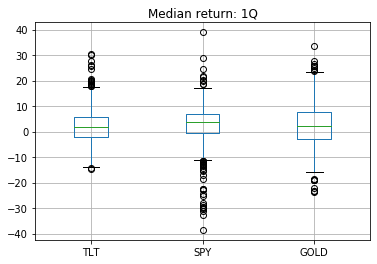

In [49]:
bp = 100*df.pct_change(periods=int(0.25*scale))
bp.boxplot(grid=True, patch_artist=False)

plt.title('Median return: 1Q')
plt.show()

Individual and portfolio metrics vice horizon:

In [50]:
df_stat, df_hor = [],[]
p_med, p_std, p_var = [], [], []

for i in range(2*scale): 
    
    df_hor.append(i/scale)
    
    df_ret = 100*df.pct_change(periods=i)
    p_ret = (1/len(df_ret.columns))*df_ret.sum(axis = 1, skipna = True)
    
    df_med = df_ret.apply(lambda x : x.median())
    df_std = df_ret.apply(lambda x : x.std())
    df_var = df_ret[df_ret <= 0].apply(lambda x : x.abs().quantile(p))
    
    p_med.append(p_ret.median())
    p_std.append(p_ret.std())
    p_var.append(np.quantile(([abs(x) for x in p_ret if x <= 0]), p))
    
    df_stat.append(pd.DataFrame({'Return': df_med, 'Standard': df_std, 'Value at risk': df_var}))

Define statistics:

In [51]:
ass_ret,ass_std,ass_var = [],[],[]

for item in range(len(df.columns)):
    
    ass_ret.append(list([float(df_stat[x]['Return'].iloc[item]) for x in range(2*scale)]))
    ass_std.append(list([float(df_stat[x]['Standard'].iloc[item]) for x in range(2*scale)]))
    ass_var.append(list([float(df_stat[x]['Value at risk'].iloc[item]) for x in range(2*scale)]))

Define annualized cumulated returns:

In [52]:
years_num = int(round(len(df)/scale))
df_cum = pd.DataFrame(round(100*(df.iloc[-1]-df.iloc[0])/df.iloc[0]))
df_annual = (df_cum.transpose()/years_num).astype('int64')

Median return vice horizon, saturation for 1/N at annual horizon:

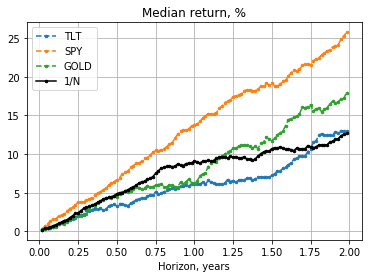

In [53]:
for i in range(len(df.columns)):
    plt.plot(df_hor[1:], ass_ret[i][1:], '.--', label=labels[i], markersize=5)

plt.plot(df_hor[1:], p_med[1:], '.-', label='1/N', color='black', markersize=5)

plt.title('Median return, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid()
plt.show()

Standard deviation vice horizon:

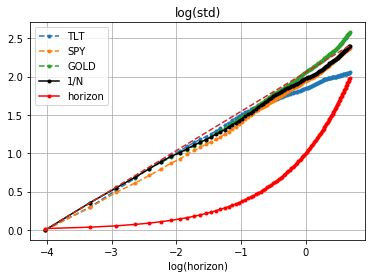

In [54]:
for i in range(len(df.columns)):
    z = np.log(ass_std[i][1:])
    y = (np.log(ass_std[i][1:]) - np.min(z))
    plt.plot(np.log(df_hor[1:]), y, '.--', label=labels[i])

z_p = np.log(p_std[1:])
y_p = (z_p - np.min(z_p))

plt.plot(np.log(df_hor[1:]), y_p, '.-', label='1/N', color='black')
plt.plot(np.log(df_hor[1:]), df_hor[1:], '.-', label='horizon', color='red')

plt.plot([np.min(np.log(df_hor[1:])), np.max(np.log(df_hor[1:]))], [np.min(y_p), np.max(y_p)], '--')

plt.title('log(std)')
plt.xlabel('log(horizon)')

plt.legend(loc='upper left')
plt.grid()
plt.show()

Value at risk (95%) vice horizon:

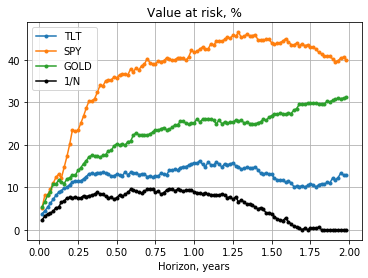

In [55]:
for i in range(len(df.columns)):
    plt.plot(df_hor[1:], ass_var[i][1:], '.-', label=labels[i])

plt.plot(df_hor[1:], p_var[1:], '.-', label='1/N', color='black')

plt.title('Value at risk, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid()
plt.show()

Return vice var relation:

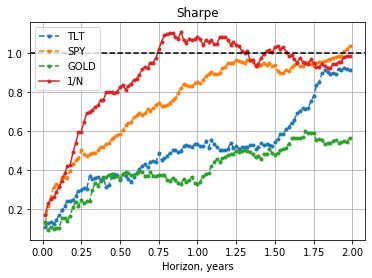

In [56]:
assets_z = []

for i in range(len(df.columns)):
    assets_z.append([wrd_div(x,y) for x, y in zip(ass_ret[i][1:], ass_std[i][1:])])
    plt.plot(df_hor[1:], [wrd_div(x,y) for x, y in zip(ass_ret[i][1:], ass_std[i][1:])][:], '.--', label=labels[i])

t = [wrd_div(x,y) for x, y in zip(p_med[1:], p_std[1:])]
plt.plot(df_hor[1:], t[:], '.-', label='1/N')

plt.axhline(y=1, color='black', linestyle='--')

plt.xlabel('Horizon, years')        
plt.title('Sharpe')

plt.legend(loc='upper left')
plt.grid()
plt.show()

ACF function vice horizon:

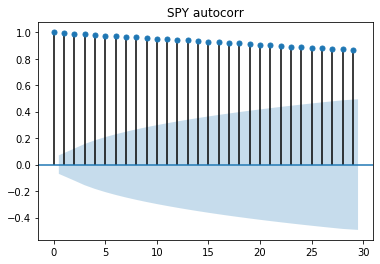

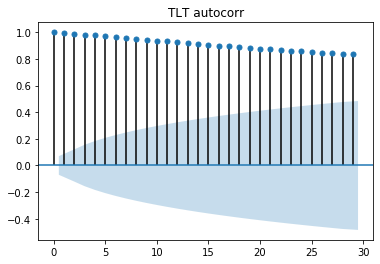

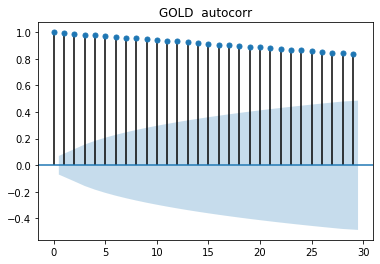

In [57]:
df_acf = pd.ExcelFile('data/data.xlsx').parse('data')[['DATE', 'TLT', 'SPY', 'GOLD']]

plot_acf(df_acf['SPY'])
plt.title('SPY autocorr')

plot_acf(df_acf['TLT'])
plt.title('TLT autocorr')

plot_acf(df_acf['GOLD'])
plt.title('GOLD  autocorr')
plt.show()

Number of years:

In [58]:
print('Number of years:', years_num)

Number of years: 14


Cumulated return of rebalanced portfolio:

In [59]:
p_cum, p_hor = [], []

for i in range(1, 2*scale):
    
    df_p = df.iloc[::i].pct_change(periods=1).dropna(axis = 0)
    df_p = df_p.sum(axis=1)/len(df.columns)
    df_p = 100*(df_p+1).product()-1
    
    p_hor.append(i/scale)
    p_cum.append(df_p)

Plot cumulated return vice holding period:

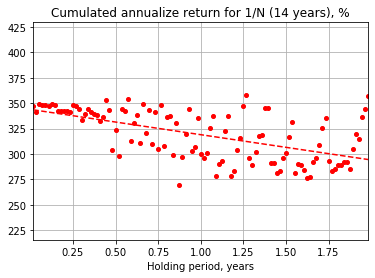

In [60]:
plt.plot(p_hor, p_cum, '.', markersize=8, color='red')

x,y = np.unique(p_hor), np.poly1d(np.polyfit(p_hor, p_cum, 1))
plt.plot(x, y(x), '--', color='red')

plt.xlim(min(p_hor), max(p_hor))
plt.ylim(0.8*min(p_cum), 1.2*max(p_cum))

plt.xlabel('Holding period, years')
plt.title('Cumulated annualize return for 1/N (14 years), %')

plt.grid(True)
plt.show()

Metrics vice horizon for 1/N portfolio with rebalancing:

In [61]:
port_ret, port_std, port_hold, port_var  = [], [], [], []
delta = int(round(0.25*scale))

for j in range(9):  
    
    df_pl = []
    
    for i in range(scale):
        df_p = df.iloc[::delta].pct_change(periods=1).dropna(axis = 0)
        df_p = 100*((0.25*df_p.sum(axis=1)+1)[i:(i+j)].product()-1)
        df_pl.append(df_p)
        
    port_ret.append(statistics.median(df_pl))
    port_std.append(statistics.stdev(df_pl))
    port_var.append(np.quantile(([abs(x) for x in df_pl if x <= 0]), p))
    
    port_hold.append(j/4)

Return vice horizon for 1/N with rebalancing and without one:

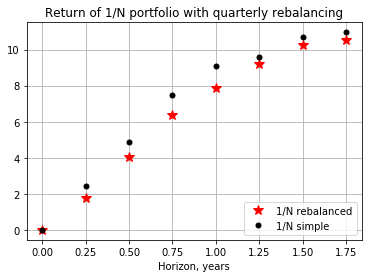

In [62]:
plt.plot(port_hold[:-1], port_ret[:-1], '*', markersize=10, color='red', label='1/N rebalanced')
plt.plot(df_hor[::delta], p_med[::delta], '.', label='1/N simple', color='black', markersize=10)

plt.title('Return of 1/N portfolio with quarterly rebalancing')
plt.xlabel('Horizon, years')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()

Value at risk vice horizon for 1/N portfolio with rebalancing and without one:

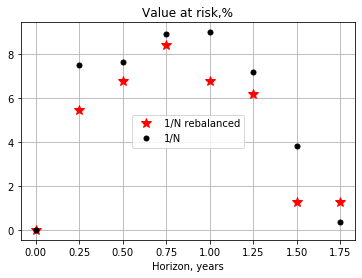

In [63]:
plt.plot(port_hold[:-1], port_var[:-1], '*', markersize=10, color='red', label='1/N rebalanced')
plt.plot(df_hor[::delta], p_var[::delta], '.', label='1/N', color='black', markersize=10)

plt.title('Value at risk,%')
plt.xlabel('Horizon, years')
plt.legend(loc='center')

plt.grid(True)
plt.show()

Return/Risk vice horizon for 1/N portfolio with rebalancing and simple 1/N: 

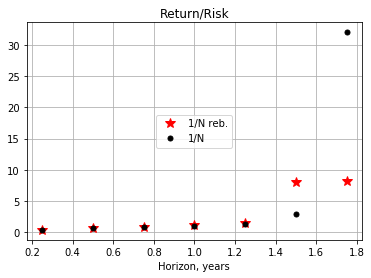

In [64]:
z = [wrd_div(x,y) for x, y in zip(port_ret, port_var)][1:]
t = [wrd_div(x,y) for x, y in zip(p_med, p_var)][::delta][1:]

plt.plot(port_hold[1:][:-1], z[:-1], '*', label='1/N reb.', color='red', markersize=10) 
plt.plot(df_hor[::delta][1:], t, '.', label='1/N', color='black', markersize=10)

plt.title('Return/Risk')
plt.xlabel('Horizon, years')
plt.legend(loc='center')

plt.grid(True)
plt.show()

Read data:

In [110]:
df = pd.ExcelFile('data/data.xlsx').parse('data')[['DATE', 'TLT', 'SPY', 'GOLD']].dropna(how='any', axis=0)
dates =  pd.to_datetime(df['DATE']).dt.date 
df = df.drop(['DATE'], axis=1) 

Retrieve moving return:

In [111]:
ret = 100*df.pct_change(periods=int(scale))

ret_below_zero = ret[ret<0] 
ret_below_zero[ret_below_zero < 0] = df

Plot reverse signal:

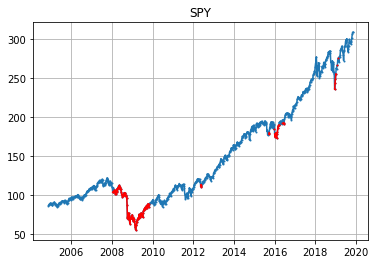

In [113]:
plt.plot(dates, df['SPY'], '.-', markersize=2)
plt.plot(dates, ret_below_zero['SPY'], '.-', markersize=2, color='red')

plt.title('SPY')
plt.grid()
plt.show()